# Optogenetic Stimulation Example

In [212]:
%load_ext autoreload
%autoreload 2

from brian2 import *
from clocsim import *

import matplotlib.pyplot as plt


# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the Brian network model
We'll use a small neuron group, biased by Poisson input spikes. Note that the opsin model is conductance-based and so depends on somewhat realistic membrane voltages. Quadratic or exponential integrate-and-fire maintain simplicity while modeling the upward membrane potential spike and should be suitable for our purposes. We'll use the exponential flavor.

In [213]:
n = 10
defaultclock.dt = .05*ms
ng = NeuronGroup(
    n,
    """
    # dv/dt = (-v - 70*mV - Rm*I) / tau : volt
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) - Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70*mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", n, 100 * Hz, 1 * mV)

mon = SpikeMonitor(ng)

net = Network(ng, input_group, mon)


## Assign coordinates and configure optogenetic model

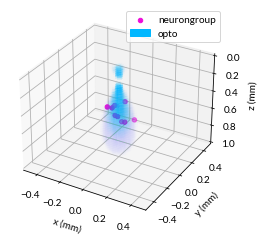

In [214]:
from clocsim.coordinates import assign_coords_rand_rect_prism, plot_neuron_positions

assign_coords_rand_rect_prism(ng, (-.1, .1), (-.1, .1), (0.4, 0.6))

from clocsim.stimulators.opto import *

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=four_state,
    opsin_params=ChR2_four_state,
    light_model_params=default_blue,
    location=(0, 0, 0.5) * mm,
)

plot_neuron_positions(ng, color='xkcd:fuchsia', xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0, 1), opto=opto)


## Open-loop optogenetic stimulation
Now for the control loop--to control neuron $i$, we need to:
- capture spiking using a `SpikeRecorder`
- estimating its firing rate using a `FiringRateEstimator`
- compute the stimulus intensity with a `PIController`
- pass that to a `StateVariableSetter` stimulator manipulating input current

### Example optogenetic stimulation setup

In [215]:
from clocsim import *
from clocsim.recorders import GroundTruthSpikeRecorder
from clocsim.stimulators import StateVariableSetter

sim = CLOCSimulator(net)
# rec = GroundTruthSpikeRecorder("spike_rec")
# sim.inject_recorder(rec, ng[i])
sim.inject_stimulator(opto, ng, Iopto_var_name='I')

# smon = StateMonitor(opto.opto_syns[ng.name], ['O1', 'C1', 'C2', 'O2'], record=0)
# I_mon = StateMonitor(ng, ['I'], record=0)
# vmon = StateMonitor(ng, 'v', record=True)
# sim.network.add(I_mon, smon, vmon)

In [216]:
from clocsim.processing import LatencyProcessingLoop

def stimulus(time_ms):
    f = 30
    # return 0
    return 1 * (1 + np.sin(2*np.pi*f * time_ms/1000))

class OpenLoopOpto(LatencyProcessingLoop):
    def __init__(self):
        super().__init__(sampling_period_ms=1)

    # since this is open-loop, we don't touch state_dict
    def compute_ctrl_signal(self, state_dict, time_ms):
        opto_intensity = stimulus(time_ms)
        return ({"opto": opto_intensity}, time_ms)

sim.set_processing_loop(OpenLoopOpto())

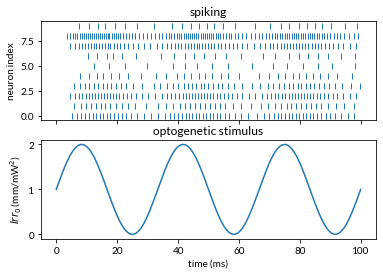

In [217]:
sim.run(100*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mon.t / ms, mon.i, '|')
ax1.set(ylabel='neuron index', title='spiking')
# t_sim = np.linspace(mon.t[0], mon.t[-1], 1000) / ms
t_sim=np.linspace(0, 100, 1000)
ax2.plot(t_sim, stimulus(t_sim))
ax2.set(ylabel=r'$Irr_0$ (mm/mW$^2$)', title='optogenetic stimulus', xlabel='time (ms)')
fig.show()